In [2]:
# Do all imports and installs here
import pandas as pd
import os
import glob
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col
from pyspark.sql.functions import expr ,lit,to_date,year, month, dayofmonth, hour, weekofyear,dayofweek, date_format
import  pyspark.sql.functions as F
from pyspark.sql.functions import *
from IPython.display import Image


In [3]:
# Create Spark session
spark = SparkSession.builder.\
appName('Data Engineer capaston projectwith Spark SQL').\
config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11")\
.enableHiveSupport().getOrCreate()

In [4]:
# output path
output_data = "/home/workspace/"

### Step 1: Scope the Project and Gather Data

#### Scope 
Explain what you plan to do in the project in more detail. What data do you use? What is your end solution look like? What tools did you use? etc>

#### Describe and Gather Data 
Describe the data sets you're using. Where did it come from? What type of information is included? 

- **Immigration Data**:is the primary dataset. It recorded the immigrant category, a port of entry, entry date into the United States, status expiration date, and a unique 11-digit identifying number assigned to it. The purpose is to keep track of the arrival and departure to/from the United States of not United States citizens. It is stored as SAS binary database storage format sas7bdat. The data is for April of 2016 which has more than three million records. The fact table is derived from this data, also TIME and PERSON dimension tables are derived from this dataset.
- **U.S. City Demographics Data**: is the second dataset. it contains information about all U.S. cities' demographics and census-designated places with a population greater or equal to 65,000. The STATE dimension in the data model is derived from this dataset and grouped by State.
- **Country Data**: This data contains code for all countries in the world. This data comes from I94_SAS_Labels_Descriptions provided by Udacity. The COUNTRY dimension in the data model is derived from this dataset.



In [5]:
# Read immigration data
i94_files = glob.glob("../../data/18-83510-I94-Data-2016/*.sas7bdat")
i94_fname = "../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat"
i94_df = spark.read.format("com.github.saurfang.sas.spark").load(i94_fname)

In [6]:
# Read demographics data
demo_fname = "us-cities-demographics.csv"
demo_df = spark.read.format("csv").option("delimiter", ";").option("header", "true").load(demo_fname)

In [7]:
# Read countries data
countries_fname = 'countries.csv'
countries_df = spark.read.format("csv").option("delimiter", ",").option("header", "true").load(countries_fname)


### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.



In [8]:
i94_df.limit(5).toPandas()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,6.0,2016.0,4.0,692.0,692.0,XXX,20573.0,NaN,None,NaN,...,U,None,1979.0,10282016,None,None,None,1.897628e+09,None,B2
1,7.0,2016.0,4.0,254.0,276.0,ATL,20551.0,1.0,AL,NaN,...,Y,None,1991.0,D/S,M,None,None,3.736796e+09,00296,F1
2,15.0,2016.0,4.0,101.0,101.0,WAS,20545.0,1.0,MI,20691.0,...,None,M,1961.0,09302016,M,None,OS,6.666432e+08,93,B2
3,16.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,None,M,1988.0,09302016,None,None,AA,9.246846e+10,00199,B2
4,17.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,None,M,2012.0,09302016,None,None,AA,9.246846e+10,00199,B2


In [9]:
demo_df.limit(5).toPandas()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601,41862,82463,1562,30908,2.6,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129,49500,93629,4147,32935,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040,46799,84839,4819,8229,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127,87105,175232,5821,33878,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040,143873,281913,5829,86253,2.73,NJ,White,76402


In [10]:
countries_df.limit(5).toPandas()

,code,country
0,582,MEXICO
1,236,AFGHANISTAN
2,101,ALBANIA
3,316,ALGERIA
4,102,ANDORRA


In [11]:
#the shapes of the given data
print(" Immigration  ")
imm_df_count=i94_df.count()
print(f"Rows: {imm_df_count}")
print(f"Columns: {len(i94_df.columns)}")
print()
print(" Demographics")
demo_df_count=demo_df.count()
print(f"Rows: {demo_df_count}")
print(f"Columns: {len(demo_df .columns)}")
print()
print(" Countries")
countries_df_count=countries_df.count()
print(f"Rows: {countries_df_count}")
print(f"Columns: {len(countries_df .columns)}")

 Immigration  
Rows: 3096313
Columns: 28

 Demographics
Rows: 2891
Columns: 12

 Countries
Rows: 289
Columns: 2


In [12]:
i94_df.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

**Data Dictionary**

| Feature | Description | 
| --- | --- |  
| cicid|Unique record ID | 
| i94yr | 4 digit year | 
| i94mon | Numeric month | 
| i94cit | 3 digit code for immigrant country of birth | 
| i94res | 3 digit code for immigrant country of residence | 
| i94port | Port of admission | 
| arrdate | Arrival Date in the USA | 
| i94mode | Mode of transportation (1 = Air; 2 = Sea; 3 = Land; 9 = Not reported) | 
| i94addr | USA State of arrival | 
| depdate | Departure Date from the USA | 
| i94bir | Age of Respondent in Years | 
| i94visa | Visa codes collapsed into three categories | 
| count | Field used for summary statistics | 
| dtadfile | Character Date Field - Date added to I-94 Files | 
| visapost | Department of State where where Visa was issued | 
| occup | Occupation that will be performed in U.S | 
| entdepa | Arrival Flag - admitted or paroled into the U.S. | 
| entdepd | Departure Flag - Departed, lost I-94 or is deceased | 
| entdepu | Update Flag - Either apprehended, overstayed, adjusted to perm residence | 
| matflag | Match flag - Match of arrival and departure records | 
| biryear | 4 digit year of birth | 
| dtaddto | Character Date Field - Date to which admitted to U.S. (allowed to stay until) | 
| gender | Non-immigrant sex | 
| insnum | INS number | 
| airline | Airline used to arrive in U.S. | 
| admnum | Admission Number | 
| fltno | Flight number of Airline used to arrive in U.S. | 
| visatype | Class of admission legally admitting the non-immigrant to temporarily stay in U.S

In [13]:
demo_df.printSchema()

root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median Age: string (nullable = true)
 |-- Male Population: string (nullable = true)
 |-- Female Population: string (nullable = true)
 |-- Total Population: string (nullable = true)
 |-- Number of Veterans: string (nullable = true)
 |-- Foreign-born: string (nullable = true)
 |-- Average Household Size: string (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: string (nullable = true)



**Data Dictionary**

| Feature | Description  | 
| --- | --- |  
| City | City Name  | 
| State | US State where city is located | 
| Median Age | Median age of the population | 
| Male Population | Count of male population | 
| Female Population | Count of female population | 
| Total Population | Count of total population | 
| Number of Veterans | Count of total Veterans | 
| Foreign born | Count of residents of the city that were not born in the city | 
| Average Household Size | Average city household size | 
| State Code | Code of the US state | 
| Race | Respondent race | 
| Count | Count of city's individual per race 

In [14]:
countries_df.printSchema()

root
 |-- code: string (nullable = true)
 |-- country: string (nullable = true)



**Data Dictionary**

| Feature | Description  | 
| --- | --- |  
| code | Code of Country | 
| country | Country Name |

#### Cleaning Steps
Document steps necessary to clean the data:

- change columns type and name. 

- drop duplicates. 

- drop un-needed columns.

- aggregate based on columns. 

**Cleansing immegration Data**

In [8]:
staging_imm_df = i94_df \
.withColumn("cicid", col("cicid").cast("integer")) \
.withColumn("bornCountry", col("i94cit").cast("integer")) \
.drop("i94cit") \
.withColumn("residentCountry", col("i94res").cast("integer")) \
.drop("i94res") \
.withColumn("year", col("i94yr").cast("integer")) \
.drop("i94yr") \
.withColumn("month", col("i94mon").cast("integer")) \
.drop("i94mon") \
.withColumnRenamed("i94port", "arrivalPort") \
.withColumn("mode", col("i94mode").cast("integer")) \
.drop("i94mode") \
.withColumnRenamed("i94addr", "State") \
.withColumn("age", col("i94bir").cast("integer")) \
.drop("i94bir") \
.withColumn("visa", col("i94visa").cast("string")) \
.drop("i94visa") \
.withColumnRenamed("entdepa", "arrivalFlag") \
.withColumnRenamed("entdepd", "departureFlag") \
.withColumnRenamed("entdepu", "updateFlag") \
.withColumnRenamed("matflag", "matchFlag") \
.withColumn("birthYear", col("biryear").cast("integer")) \
.drop("biryear") \
.withColumnRenamed("fltno", "flightNumber") \
.withColumn("sasDate", to_date(lit("01/01/1960"), "MM/dd/yyyy")) \
.withColumn("arrivalDate", expr("date_add(sasDate, arrdate)")) \
.withColumn("departureDate", expr("date_add(sasDate, depdate)")) \
.withColumnRenamed("occup", "occupation") \
.withColumnRenamed("admnum", "admission_number") \
.withColumnRenamed("visapost", "vissa_issued_state") \
.drop("sasDate", "arrdate", "depdate", "count",  "dtadfile", "dtaddto",'airline','fltno','visatype')

In [16]:

print("Staging Immigration data schema:")
staging_imm_df.printSchema()

Staging Immigration data schema:
root
 |-- cicid: integer (nullable = true)
 |-- arrivalPort: string (nullable = true)
 |-- State: string (nullable = true)
 |-- vissa_issued_state: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- arrivalFlag: string (nullable = true)
 |-- departureFlag: string (nullable = true)
 |-- updateFlag: string (nullable = true)
 |-- matchFlag: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- admission_number: double (nullable = true)
 |-- flightNumber: string (nullable = true)
 |-- bornCountry: integer (nullable = true)
 |-- residentCountry: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- mode: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- visa: string (nullable = true)
 |-- birthYear: integer (nullable = true)
 |-- arrivalDate: date (nullable = true)
 |-- departureDate: date (nullable = true)



In [17]:
def count_missings(spark_df,sort=True):
    """
    Counts number of nulls and nans in each column
    Param spark_df ; spark datafram to check missing on
    """
    df = spark_df.select([F.count(F.when(F.isnan(c) | F.isnull(c), c)).alias(c) for (c,c_type) in spark_df.dtypes if c_type not in ('timestamp', 'date')]).toPandas()

    if len(df) == 0:
        print("There are no any missing values!")
        return None

    if sort:
        return df.rename(index={0: 'count'}).T.sort_values("count",ascending=False)
         
    return df

In [18]:
count_missings(staging_imm_df)

,count
updateFlag,3095921
occupation,3088187
insnum,2982605
vissa_issued_state,1881250
gender,414269
State,152592
departureFlag,138429
matchFlag,138429
flightNumber,19549
age,802


In [9]:
# Drop columns with over 2M missing values
cols = ['updateFlag', 'occupation','insnum']

# drop these columns
staging_imm_df = staging_imm_df.drop(*cols)

In [10]:
#drop duplicates
staging_imm_df = staging_imm_df.dropDuplicates(['cicid'])

In [11]:
# drop any row with null for 'vissa_issued_state','gender','visa','age'
staging_imm_df1 = staging_imm_df.dropna(how='any',subset=('vissa_issued_state','gender','visa','age'))

In [22]:
staging_imm_df1.select('gender').distinct().show()

+------+
|gender|
+------+
|     F|
|     M|
|     U|
|     X|
+------+



In [12]:
# change value of visa to actual value
staging_imm_df1 = staging_imm_df1.withColumn('visa', regexp_replace('visa', '1.0', 'Business'))\
.withColumn('visa', regexp_replace('visa', '2.0', 'Pleasure'))\
.withColumn('visa', regexp_replace('visa', '3.0', 'Student'))

In [13]:
# change value of mode to actual value
staging_imm_df1 = staging_imm_df1.withColumn('mode', regexp_replace('mode', '1', 'Sea'))\
.withColumn('mode', regexp_replace('mode', '2', 'Air'))\
.withColumn('mode', regexp_replace('mode', '3', 'Land'))\
.withColumn('mode', regexp_replace('mode', '9', 'Not Reported'))

In [25]:
staging_imm_df1.select('visa').distinct().show()

+--------+
|    visa|
+--------+
|Pleasure|
| Student|
|Business|
+--------+



In [29]:
staging_imm_df1.select('mode').distinct().show()

+------------+
|        mode|
+------------+
|Not Reported|
|         Sea|
|        Land|
|         Air|
+------------+



In [30]:
staging_imm_df1.limit(5).toPandas()

,cicid,arrivalPort,State,vissa_issued_state,arrivalFlag,departureFlag,matchFlag,gender,admission_number,flightNumber,bornCountry,residentCountry,year,month,mode,age,visa,birthYear,arrivalDate,departureDate
0,2122,WAS,VA,SOF,G,O,M,M,9.247317e+10,00093,105,105,2016,4,Sea,59,Pleasure,1957,2016-04-01,2016-04-15
1,2142,NYC,NY,SOF,G,O,M,M,9.246658e+10,00049,105,105,2016,4,Sea,50,Pleasure,1966,2016-04-01,2016-04-12
2,2366,NYC,NJ,KRK,G,None,None,F,9.251262e+10,00026,107,107,2016,4,Sea,27,Pleasure,1989,2016-04-01,None
3,12027,CHI,GA,ATH,G,O,M,M,9.249945e+10,00087,113,113,2016,4,Sea,77,Pleasure,1939,2016-04-01,2016-07-28
4,12046,MIA,CA,BGN,G,O,M,M,9.246763e+10,00982,113,113,2016,4,Sea,40,Business,1976,2016-04-01,2016-04-06


**Write to parquet files patitioned by year an month**

In [31]:
staging_imm_df1.write.mode('overwrite').partitionBy("year","month").parquet(output_data+'immegration_staging/')

**Cleansing for demographic data**

In [32]:
count_missings(demo_df)

,count
Average Household Size,16
Number of Veterans,13
Foreign-born,13
Male Population,3
Female Population,3
City,0
State,0
Median Age,0
Total Population,0
State Code,0


In [34]:
demo_df.printSchema()

root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median Age: string (nullable = true)
 |-- Male Population: string (nullable = true)
 |-- Female Population: string (nullable = true)
 |-- Total Population: string (nullable = true)
 |-- Number of Veterans: string (nullable = true)
 |-- Foreign-born: string (nullable = true)
 |-- Average Household Size: string (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: string (nullable = true)



In [14]:
Staging_demo_df = demo_df \
.withColumn("MedianAge", col("Median Age").cast("integer")) \
.withColumn("MalePopulation", col("Male Population").cast("integer")) \
.withColumn("FemalePopulation", col("Female Population").cast("integer")) \
.withColumn("TotalPopulation", col("Total Population").cast("integer")) \
.withColumn("NumberOfVeterans", col("Number of Veterans").cast("integer")) \
.withColumn("Foreign-born", col("Foreign-born").cast("integer")) \
.withColumn("AverageHouseholdSize", col("Average Household Size").cast("integer")) \
.withColumn("Count", col("Count").cast("integer"))\
.withColumn("StateCode", col("State Code"))\
.drop("Median Age", "Male Population", "Female Population", "Number of Veterans",  "Average Household Size", "State Code")

In [15]:
print("Staging deographics data schema:")
Staging_demo_df.printSchema()

Staging deographics data schema:
root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Total Population: string (nullable = true)
 |-- Foreign-born: integer (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: integer (nullable = true)
 |-- MedianAge: integer (nullable = true)
 |-- MalePopulation: integer (nullable = true)
 |-- FemalePopulation: integer (nullable = true)
 |-- TotalPopulation: integer (nullable = true)
 |-- NumberOfVeterans: integer (nullable = true)
 |-- AverageHouseholdSize: integer (nullable = true)
 |-- StateCode: string (nullable = true)



**aggregate demographics data based on State,State Code and City**

In [16]:
Staging_demo_df = Staging_demo_df.groupBy(col("StateCode"), col("State"),col("City")).agg(
round(mean('MedianAge'), 2),\
sum("TotalPopulation"),\
sum("MalePopulation"), \
sum("FemalePopulation"),\
sum("NumberOfVeterans"),\
sum("Foreign-born"),\
round(mean("AverageHouseholdSize"),2)
).dropna()

In [17]:
Staging_demo_df = Staging_demo_df.withColumnRenamed('round(avg(MedianAge), 2)','MedianAge')\
.withColumnRenamed('sum(TotalPopulation)','TotalPopulation')\
.withColumnRenamed('sum(MalePopulation)','MalePopulation')\
.withColumnRenamed('sum(FemalePopulation)','FemalePopulation')\
.withColumnRenamed('sum(NumberOfVeterans)','NumberOfVeterans')\
.withColumnRenamed('sum(Foreign-born)','Foreign-born')\
.withColumnRenamed('round(avg(AverageHouseholdSize), 2)','AverageHouseholdSize')

In [39]:
Staging_demo_df.printSchema()

root
 |-- StateCode: string (nullable = true)
 |-- State: string (nullable = true)
 |-- City: string (nullable = true)
 |-- MedianAge: double (nullable = true)
 |-- TotalPopulation: long (nullable = true)
 |-- MalePopulation: long (nullable = true)
 |-- FemalePopulation: long (nullable = true)
 |-- NumberOfVeterans: long (nullable = true)
 |-- Foreign-born: long (nullable = true)
 |-- AverageHouseholdSize: double (nullable = true)



In [40]:
Staging_demo_df.limit(5).toPandas()

,StateCode,State,City,MedianAge,TotalPopulation,MalePopulation,FemalePopulation,NumberOfVeterans,Foreign-born,AverageHouseholdSize
0,MD,Maryland,Silver Spring,33.0,412315,203005,209310,7810,154540,2.0
1,WA,Washington,Seattle,35.0,3422215,1728295,1693920,146820,599200,2.0
2,TX,Texas,Grand Prairie,33.0,938775,454055,484720,35365,224440,3.0
3,IL,Illinois,Rockford,36.0,746730,355380,391350,44470,91615,2.0
4,MI,Michigan,Westland,39.0,409975,188710,221265,23780,32145,2.0


**Write to parquet file**

In [41]:
Staging_demo_df.write.mode('overwrite').parquet(output_data+'demographics_staging/')

**Cleansing for Countries data**

In [18]:
# delete unneeded data
Staging_countries_df = countries_df.select('code','country').where("country not like 'INVALID%'").select('code','country')\
.where("country not like 'No Country Code%'")\
.where("country not like 'Collapsed%'")
#Staging_countries_df1 = Staging_countries_df.select('country').where("country not like 'No Country Code%'")

In [43]:
Staging_countries_df.limit(5).toPandas()

,code,country
0,582,MEXICO
1,236,AFGHANISTAN
2,101,ALBANIA
3,316,ALGERIA
4,102,ANDORRA


**Write to parquet file**

In [44]:
Staging_countries_df.write.mode('overwrite').parquet(output_data+'countries_staging/')

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
Map out the conceptual data model and explain why you chose that model

For the project, Star schemas create a fact table linked to associated dimension tables via primary/ foreign key relationships.
- The country dimension table contains valid code and relevant countries for allows analysts to map between code and relevant country.
- The U.S. demographics dimension table comes from the demographics dataset and links to the immigration fact table at the U.S. state level. This   dimension would allow analysts to get insights into migration patterns into the U.S. based on demographics and states' overall population. 
- The person dimension tabla comes from the immigration dataset and links to the immigration fact table with cicid. This dimension would allow analysts to get insights into migration data such as age, gender, and nationality.
- The time dimension tabla comes from the immigration dataset and links to the immigration fact table with arrivalDate. This dimension would allow analysts to get insights about arrival date in more detail.
- The immigration fact table this table's data comes from the immigration dataset and contains keys that link to the dimension tables also with columns needed to have more understand the migrant status such as visa,visa_type, and port.




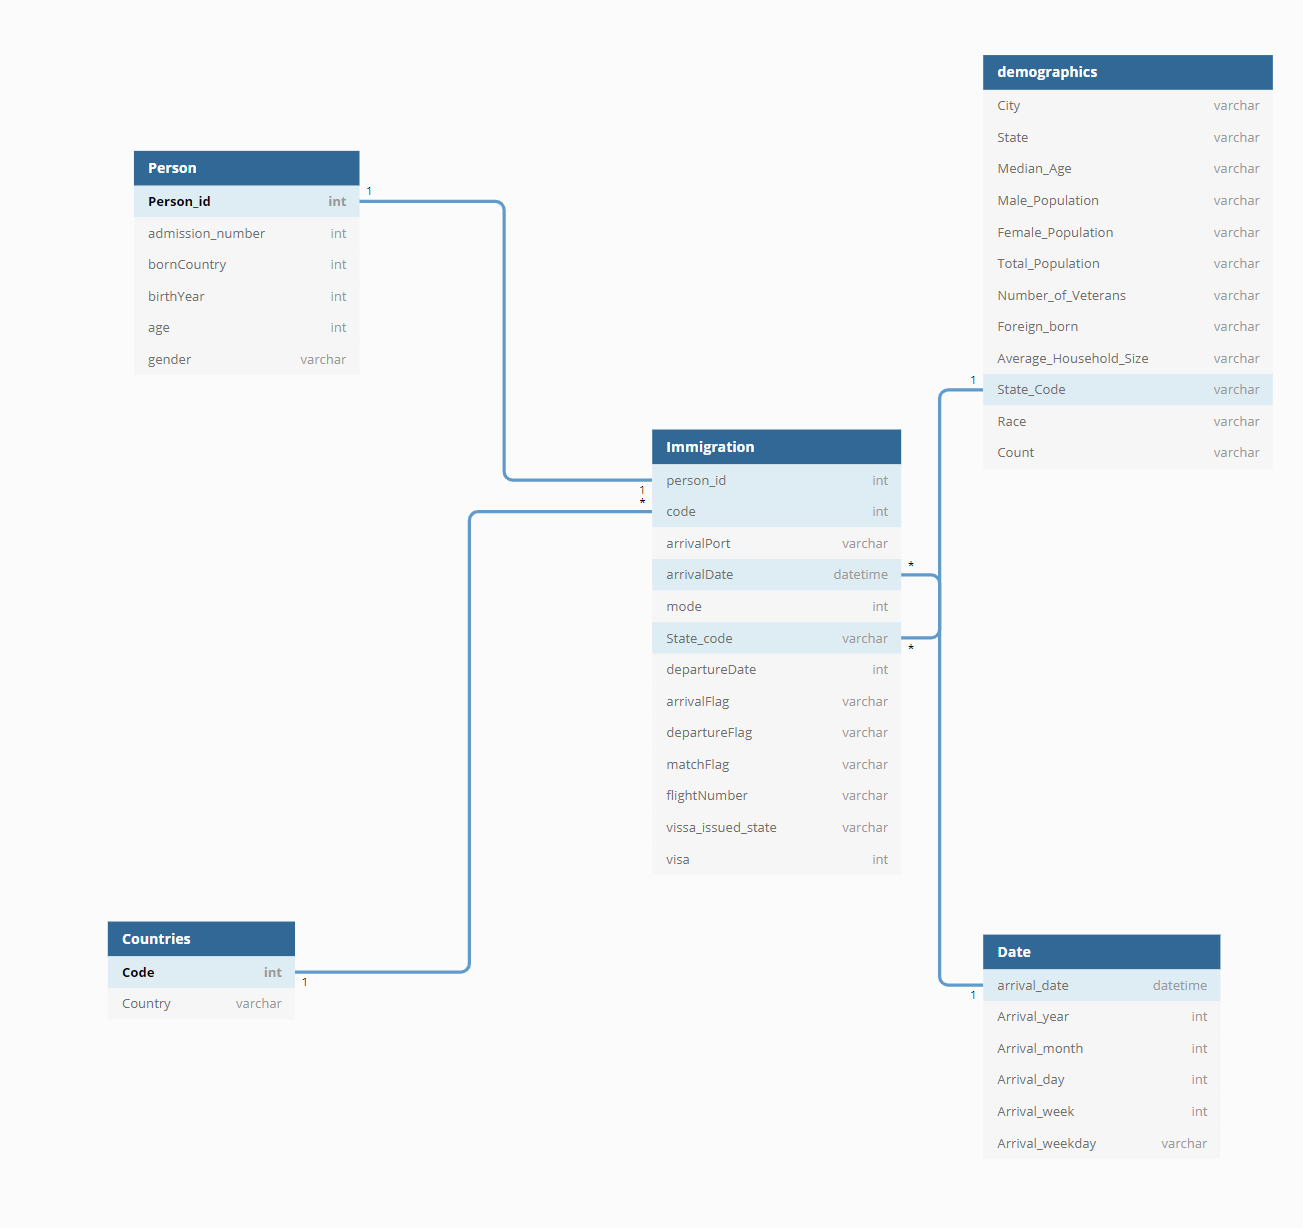

In [73]:
Image(filename = "data_model.png", width = 600, height = 300)

#### 3.2 Mapping Out Data Pipelines
List the steps necessary to pipeline the data into the chosen data model
 
The pipeline steps are as follows:
- Load and clean all the datasets and save them as staging tables
- Create a person dimension table
- Create a time dimension table
- Create a demographic dimension table
- Create a country dimension table
- Create an immigration fact table

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

**Create fact and dimension tables**

In [19]:
#  create a view of the immigration dataset
staging_imm_df1.createOrReplaceTempView("immigration_staging_table")

**Dimension Table: person table**

In [20]:
person_table = spark.sql("""
        
        SELECT DISTINCT cicid as person_id,bornCountry, birthYear, gender,age ,admission_number
        FROM immigration_staging_table
        
        """)



In [49]:
person_table.limit(5).toPandas()

,person_id,bornCountry,birthYear,gender,age,admission_number
0,221209,105,1974,F,42,9.257747e+10
1,417197,687,1975,F,41,9.259211e+10
2,806482,691,1964,M,52,9.272597e+10
3,1037948,245,1956,F,60,9.288491e+10
4,1544612,687,1998,M,18,7.326250e+08


In [50]:
print((person_table.count(), len(person_table.columns)))

(1214152, 6)


In [21]:
person_table.createOrReplaceTempView("person_table")

**Dimension Table: time table**

In [22]:
Arrivale_Date_table = staging_imm_df1.withColumn("day",F.dayofmonth("arrivalDate"))\
                    .withColumn("week",F.weekofyear("arrivalDate"))\
                    .withColumn("month",F.month("arrivalDate"))\
                    .withColumn("year",F.year("arrivalDate"))\
                    .withColumn("weekday",F.dayofweek("arrivalDate"))\
                    .select("arrivalDate","day","week", "month", "year", "weekday")
time_table = Arrivale_Date_table.dropDuplicates(['arrivalDate'])

In [53]:
time_table.limit(5).toPandas()

,arrivalDate,day,week,month,year,weekday
0,2016-04-25,25,17,4,2016,2
1,2016-04-22,22,16,4,2016,6
2,2016-04-30,30,17,4,2016,7
3,2016-04-26,26,17,4,2016,3
4,2016-04-04,4,14,4,2016,2


In [54]:
print((time_table.count(), len(time_table.columns)))

(30, 6)


In [23]:
time_table.createOrReplaceTempView("time_table")

**Dimension Table: time table**

In [24]:
# create a view of the country dataset
Staging_countries_df.createOrReplaceTempView("Country_table")

In [25]:
country_table = spark.sql("""
        
        SELECT DISTINCT code, country
        FROM Country_table
        
        """)

In [58]:
print((country_table.count(), len(country_table.columns)))

(236, 2)


**Dimension Table: demographics table**

In [26]:
# create a view of the dmographic dataset
Staging_demo_df.createOrReplaceTempView("demographic_table")

In [27]:
demographic_table = spark.sql("""
        
        SELECT *
        FROM demographic_table
        
        """)

In [61]:
print((demographic_table.count(), len(demographic_table.columns)))

(588, 10)


In [62]:
demographic_table.limit(5).toPandas()

,StateCode,State,City,MedianAge,TotalPopulation,MalePopulation,FemalePopulation,NumberOfVeterans,Foreign-born,AverageHouseholdSize
0,MD,Maryland,Silver Spring,33.0,412315,203005,209310,7810,154540,2.0
1,WA,Washington,Seattle,35.0,3422215,1728295,1693920,146820,599200,2.0
2,TX,Texas,Grand Prairie,33.0,938775,454055,484720,35365,224440,3.0
3,IL,Illinois,Rockford,36.0,746730,355380,391350,44470,91615,2.0
4,MI,Michigan,Westland,39.0,409975,188710,221265,23780,32145,2.0


**Fact Table: immegration table**

In [28]:
immegration_table = spark.sql(""" 
    
        SELECT  DISTINCT 
                p.person_id,
                c.code as country_code,
                i.arrivalPort,
                t.arrivalDate,
                i.mode,
                d.statecode as state_code,
                i.departureDate,
                i.arrivalFlag,
                i.departureFlag,
                i.matchFlag,
                i.flightNumber,
                i.vissa_issued_state,
                i.visa        
        FROM immigration_staging_table i
        JOIN
        person_table p
        ON  i.cicid  = p.person_id
        JOIN
         Country_table c
        ON i.residentCountry = c.code
        JOIN
        demographic_table d
        ON i.state = d.statecode
        JOIN
        time_table t
        ON i.arrivalDate = t.arrivalDate

                                 
        """)


In [31]:
immegration_table.limit(5).toPandas()

,person_id,country_code,arrivalPort,arrivalDate,mode,state_code,departureDate,arrivalFlag,departureFlag,matchFlag,flightNumber,vissa_issued_state,visa
0,4668589,101,NEW,2016-04-25,Sea,FL,2016-08-06,G,O,M,00089,TIA,Pleasure
1,4670175,107,NEW,2016-04-25,Sea,NJ,2016-05-09,G,O,M,00909,KRK,Pleasure
2,4670539,107,CHI,2016-04-25,Sea,IL,2016-05-09,G,O,M,00430,WRW,Pleasure
3,4670633,131,NYC,2016-04-25,Sea,NY,2016-05-03,G,O,M,00016,BEN,Pleasure
4,4676760,111,MIA,2016-04-25,Sea,FL,2016-05-01,G,N,M,01489,PTP,Pleasure


In [67]:
print((immegration_table.count(), len(immegration_table.columns)))

(1140736, 13)


#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

- In this project, the Count of tables is used to check tables to ensure completeness.

In [68]:
# Perform quality checks here
def DQ_checks(table):
    """
     Count checks on fact and dimension tables to ensure if table contains records or not.
     param table:table to check counts on
    """
    count = table.count()

    if count == 0:
        print(f"Data quality check failed with zero records!")
    else:
        print(f"Data quality check passed with {count:,} records.")
    return 0

In [69]:
# Performing DQ cheking tasks here
print("Immigration ")
DQ_checks(immegration_table)
print()
print("Demographics")
DQ_checks(demographic_table)
print()
print("Countries")
DQ_checks(country_table)
print()
print('person')
DQ_checks(person_table)
print()
print('time')
DQ_checks(time_table)
print()

 Immigration  
Data quality check passed with 1,140,736 records.

 Demographics
Data quality check passed with 588 records.

 Countries
Data quality check passed with 236 records.

person
Data quality check passed with 1,214,152 records.

time
Data quality check passed with 30 records.



In [35]:
def table_exists(table):
    if table is not None:
        print(f"data quality check passed, table {table} is exist")
        print()   
    else:
        print(f"data quality check failed, table {table} is not exist")
    return 0


In [36]:
print("Immigration ")
table_exists(immegration_table)
print()
print("Demographics")
table_exists(demographic_table)
print()
print("Countries")
table_exists(country_table)
print()
print('person')
table_exists(person_table)
print()
print('time')
table_exists(time_table)
print()

Immigration 
data quality check passed, table DataFrame[person_id: int, country_code: string, arrivalPort: string, arrivalDate: date, mode: string, state_code: string, departureDate: date, arrivalFlag: string, departureFlag: string, matchFlag: string, flightNumber: string, vissa_issued_state: string, visa: string] is exist


Demographics
data quality check passed, table DataFrame[StateCode: string, State: string, City: string, MedianAge: double, TotalPopulation: bigint, MalePopulation: bigint, FemalePopulation: bigint, NumberOfVeterans: bigint, Foreign-born: bigint, AverageHouseholdSize: double] is exist


Countries
data quality check passed, table DataFrame[code: string, country: string] is exist


person
data quality check passed, table DataFrame[person_id: int, bornCountry: int, birthYear: int, gender: string, age: int, admission_number: double] is exist


time
data quality check passed, table DataFrame[arrivalDate: date, day: int, week: int, month: int, year: int, weekday: int] is 

#### Step 5: Complete Project Write Up
 The rationale for the choice of tools and technologies for the project
       
  Apache spark used because of:
- The ability to handle multiple file formats with large amounts of data.
- The ability to handle large-scale data with speed.
- Spark accelerates the delivery of insight with in-memory processing across a distributed framework.


Propose how often the data should be updated and why.
- Data will be updated on a monthly basis.


Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
  - In this scenario, increasing the number of nodes in a cluster to handle big data.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
  - In this scenario, Apache Airflow is suitable to schedule and run data pipelines.
 * The database needed to be accessed by 100+ people.
  - In this scenario, using scalable cloud data warehouses technology like AWS redshift.

**Resources:**
https://stackoverflow.com/questions/44627386/how-to-find-count-of-null-and-nan-values-for-each-column-in-a-pyspark-dataframe
https://stackoverflow.com/questions/51949414/read-sas-sas7bdat-data-with-spark
https://www.ibmbigdatahub.com/blog/who-uses-spark-and-why#:~:text=Spark%20helps%20data%20scientists%20by,%2Dlearning%20library%20(MLlib
